4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 1/234, d1=0.692, d2=1.192 g=0.680
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 2/234, d1=0.648, d2=0.732 g=0.707
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 3/234, d1=0.675, d2=0.683 g=0.720
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 4/234, d1=0.672, d2=0.665 g=0.728
4/4 [==============================] - 0s 7ms/step
>Epoch: 1, 5/234, d1=0.646, d2=0.644 g=0.742
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 6/234, d1=0.572, d2=0.563 g=0.804
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 7/234, d1=0.430, d2=0.337 g=0.654
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 8/234, d1=0.335, d2=0.107 g=0.044
4/4 [==============================] - 0s 5ms/step
>Epoch: 1, 9/234, d1=0.028, d2=0.022 g=0.007
4/4 [==============================] - 0s 5ms/step
>Epoch: 1, 10/234, d1=0.016, d2=0.007 g=0.001
4/4 [==============================] - 

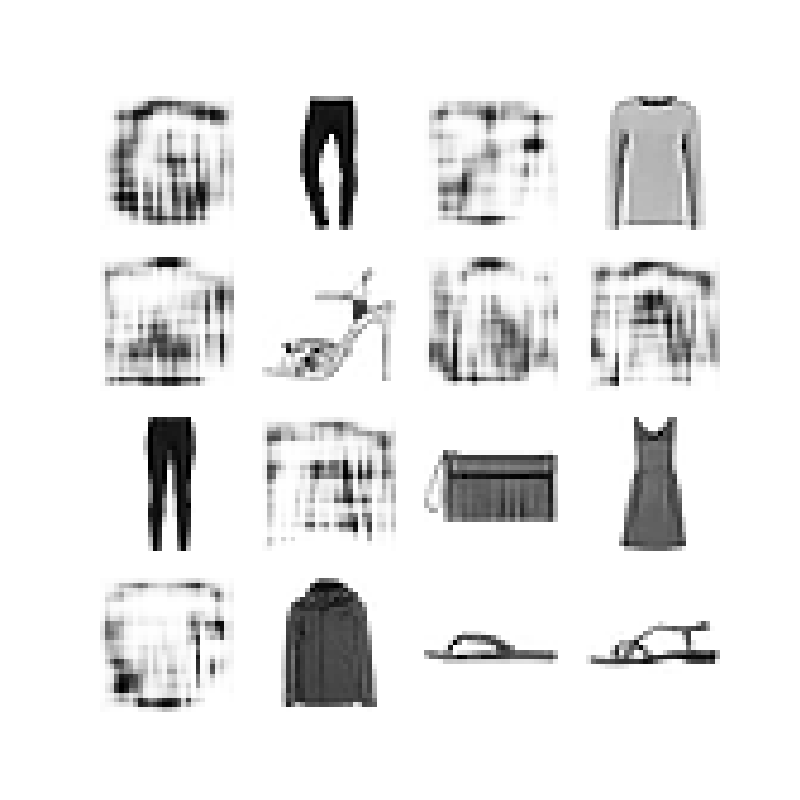

4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 1/234, d1=0.032, d2=0.010 g=0.022
4/4 [==============================] - 0s 7ms/step
>Epoch: 11, 2/234, d1=0.016, d2=0.037 g=0.014
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 3/234, d1=0.005, d2=0.036 g=0.023
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 4/234, d1=0.048, d2=0.017 g=0.023
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 5/234, d1=0.005, d2=0.018 g=0.026
4/4 [==============================] - 0s 3ms/step
>Epoch: 11, 6/234, d1=0.041, d2=0.015 g=0.021
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 7/234, d1=0.011, d2=0.016 g=0.038
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 8/234, d1=0.012, d2=0.019 g=0.063
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 9/234, d1=0.032, d2=0.013 g=0.025
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 10/234, d1=0.009, d2=0.014 g=0.036
4/4 [========================

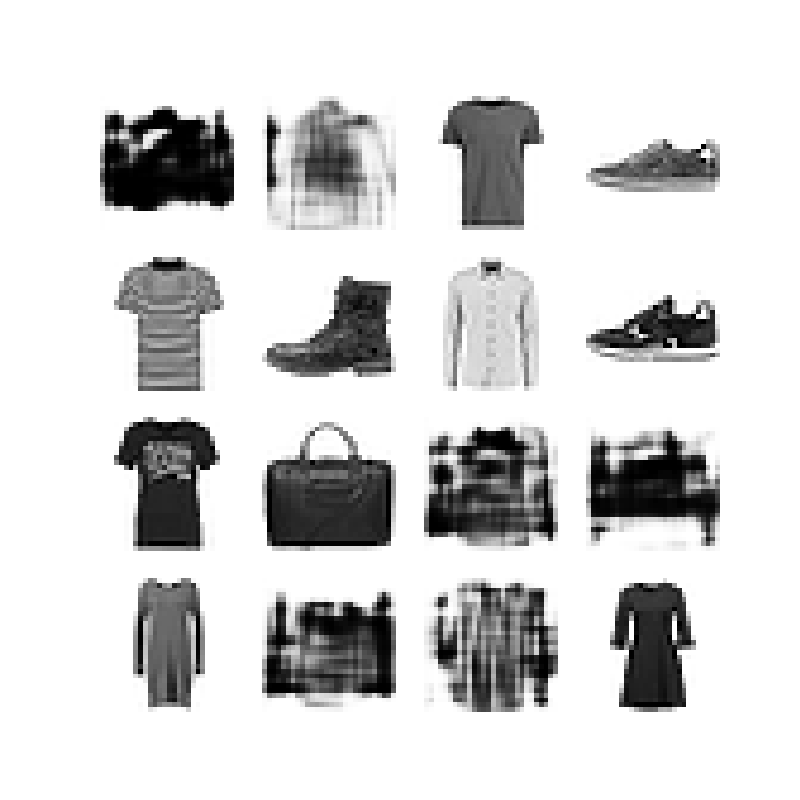

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from IPython.display import Image, display
import random

# Load and prepare mnist dataset
def load_real_samples():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

# Define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(32, (5,5), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the standalone generator model
def define_generator(latent_dim=100):
    model = Sequential()
    n_nodes = 7*7*192
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,192)))
    model.add(Dropout(0.4))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(96, (5,5), strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(48, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(24, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (5,5),strides=(1,1),activation='sigmoid', padding='same'))
    return model

# Define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Generate n real samples with class labels
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

# Create and save a plot of generated images
# Create and save a plot of generated images (16 images per group)
def save_plot(examples, epoch, n=4):
    # Create a figure for the generated images
    fig, axs = plt.subplots(n, n, figsize=(n, n))
    for i in range(n*n):
        axs[i // n, i % n].imshow(examples[i, :, :, 0], cmap='gray_r')
        axs[i // n, i % n].axis('off')
    # Save the figure
    filename = f'generated_plot_epoch_{epoch+1}.png'
    plt.savefig(filename)
    plt.close()


# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256, save_interval=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
     # Initialize lists to store loss values
    d_losses, g_losses = [], []
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Save losses
            d_losses.append((d_loss1 + d_loss2) / 2)
            g_losses.append(g_loss)
            print(f'>Epoch: {i+1}, {j+1}/{bat_per_epo}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}')
        if (i+1) % save_interval == 0 or i == n_epochs - 1:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Training Losses')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_losses.png')
    plt.close()

# Summarize the performance of the GAN
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=16):
    # Generate random indices for 16 images
    random_indices = random.sample(range(dataset.shape[0]), n_samples)
    # Select 16 random images from the dataset
    selected_images = dataset[random_indices]

    # Generate fake examples
    X_fake, _ = generate_fake_samples(generator, latent_dim, n_samples)

    # Create a combined array of real and generated images
    combined_images = np.vstack([selected_images, X_fake])

    # Shuffle the images for better visualization
    np.random.shuffle(combined_images)

    # Create a figure for the generated and real images
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    count = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(combined_images[count, :, :, 0], cmap='gray_r')
            axs[i, j].axis('off')
            count += 1

    # Save the figure
    filename = f'generated_plot_epoch_{epoch+1}.png'
    plt.savefig(filename)
    plt.close()

    # Display the saved plot
    display(Image(filename))


# Size of the latent space
latent_dim = 100
# Create the discriminator
discriminator = define_discriminator()
# Create the generator
generator = define_generator(latent_dim)
# Create the GAN
gan = define_gan(generator, discriminator)
# Load image data
dataset = load_real_samples()
# Train the GAN
train(generator, discriminator, gan, dataset, latent_dim,n_epochs=20, n_batch=256, save_interval=10)




In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization,Input, GaussianNoise
from keras.models import Sequential,Model
from keras.optimizers import Adam
from IPython.display import Image, display
import random

# Load and prepare mnist dataset
def load_real_samples():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

# Define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(32, (5,5), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (5,5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the standalone generator model
def define_generator(latent_dim=100):
    model = Sequential()
    n_nodes = 7*7*192
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,192)))
    model.add(Dropout(0.4))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(96, (5,5), strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2DTranspose(48, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(24, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (5,5),strides=(1,1),activation='sigmoid', padding='same'))
    return model

def define_denoising_model(input_shape=(28, 28, 1)):
    input_img = Input(shape=input_shape)
    # Encoder
    x = GaussianNoise(0.1)(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # Decoder
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # Output layer
    denoised_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Model
    denoising_model = Model(input_img, denoised_img)
    denoising_model.compile(optimizer='adam', loss='binary_crossentropy')

    return denoising_model

# Define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 1/234, d1=0.697, d2=0.962 g=0.691
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 2/234, d1=0.667, d2=0.716 g=0.706
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 3/234, d1=0.673, d2=0.687 g=0.715
4/4 [==============================] - 0s 4ms/step
>Epoch: 1, 4/234, d1=0.657, d2=0.676 g=0.726
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 5/234, d1=0.600, d2=0.660 g=0.777
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 6/234, d1=0.479, d2=0.530 g=0.863
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 7/234, d1=0.232, d2=0.241 g=0.656
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 8/234, d1=0.084, d2=0.027 g=0.008
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 9/234, d1=0.002, d2=0.009 g=0.001
4/4 [==============================] - 0s 3ms/step
>Epoch: 1, 10/234, d1=0.000, d2=0.002 g=0.001
4/4 [==============================] - 

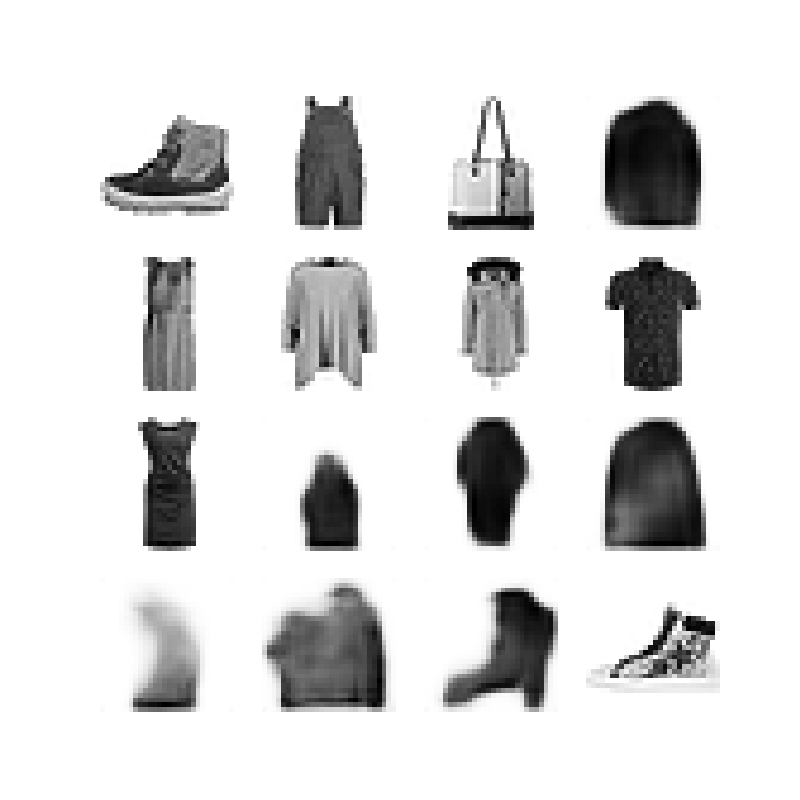

4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 1/234, d1=0.456, d2=0.342 g=2.542
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 2/234, d1=0.551, d2=0.397 g=1.813
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 3/234, d1=0.351, d2=0.442 g=2.430
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 4/234, d1=0.554, d2=0.378 g=2.172
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 5/234, d1=0.373, d2=0.402 g=2.083
4/4 [==============================] - 0s 4ms/step
>Epoch: 11, 6/234, d1=0.524, d2=0.448 g=2.177
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 7/234, d1=0.404, d2=0.269 g=2.096
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 8/234, d1=0.389, d2=0.280 g=1.817
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 9/234, d1=0.420, d2=0.443 g=2.089
4/4 [==============================] - 0s 5ms/step
>Epoch: 11, 10/234, d1=0.386, d2=0.287 g=1.891
4/4 [========================

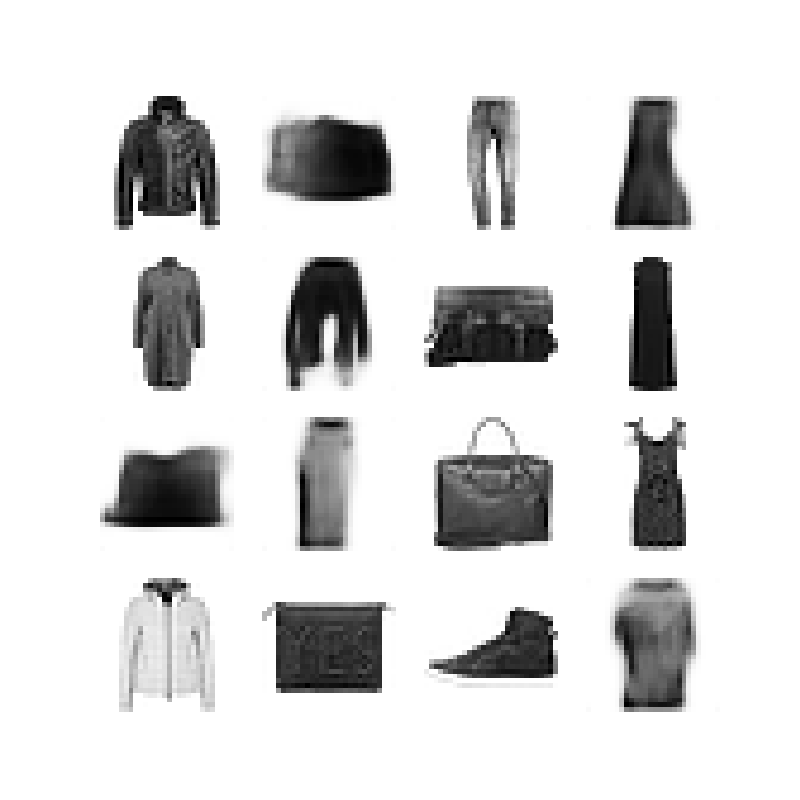

In [3]:

# Generate n real samples with class labels
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

# Create and save a plot of generated images
# Create and save a plot of generated images (16 images per group)
def save_plot(examples, epoch, n=4):
    # Create a figure for the generated images
    fig, axs = plt.subplots(n, n, figsize=(n, n))
    for i in range(n*n):
        axs[i // n, i % n].imshow(examples[i, :, :, 0], cmap='gray_r')
        axs[i // n, i % n].axis('off')
    # Save the figure
    filename = f'generated_plot_epoch_{epoch+1}.png'
    plt.savefig(filename)
    plt.close()


# Train the generator and discriminator
def train(g_model, d_model, gan_model, denoising_model, dataset, latent_dim, n_epochs=20, n_batch=256, save_interval=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
     # Initialize lists to store loss values
    d_losses, g_losses = [], []
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Save losses
            d_losses.append((d_loss1 + d_loss2) / 2)
            g_losses.append(g_loss)
            print(f'>Epoch: {i+1}, {j+1}/{bat_per_epo}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}')
        if (i+1) % save_interval == 0 or i == n_epochs - 1:
            summarize_performance(i, g_model, d_model,denoising_model, dataset, latent_dim)
    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Training Losses')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_losses.png')
    plt.close()

# Summarize the performance of the GAN
def summarize_performance(epoch, generator, discriminator, denoising_model,dataset, latent_dim, n_samples=16):
    # Generate random indices for 16 images
    random_indices = random.sample(range(dataset.shape[0]), n_samples)
    # Select 16 random images from the dataset
    selected_images = dataset[random_indices]

    # Generate fake examples
    X_fake, _ = generate_fake_samples(generator, latent_dim, n_samples)

     # Denoise the generated images
    X_denoised = denoising_model.predict(X_fake)
    # Create a combined array of real and generated images
    combined_images = np.vstack([selected_images, X_denoised])

    # Shuffle the images for better visualization
    np.random.shuffle(combined_images)

    # Create a figure for the generated and real images
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    count = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(combined_images[count, :, :, 0], cmap='gray_r')
            axs[i, j].axis('off')
            count += 1

    # Save the figure
    filename = f'generated_plot_epoch_{epoch+1}.png'
    plt.savefig(filename)
    plt.close()

    # Display the saved plot
    display(Image(filename))


# Size of the latent space
latent_dim = 100
# Create the discriminator
discriminator = define_discriminator()
# Create the generator
generator = define_generator(latent_dim)
# Create the GAN
gan = define_gan(generator, discriminator)
# Load image data
dataset = load_real_samples()
# Initialize the denoising model
denoising_model = define_denoising_model()
noisy_dataset = dataset + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=dataset.shape)
noisy_dataset = np.clip(noisy_dataset, 0., 1.)
# Train the denoising model with noisy images
denoising_model.fit(noisy_dataset, dataset, batch_size=128, shuffle=True)
# Train the GAN
train(generator, discriminator, gan, denoising_model,dataset, latent_dim, n_epochs=20, n_batch=256, save_interval=10)




In [8]:
discriminator = define_discriminator()
discriminator.save('discriminator.h5')
generator = define_generator()
generator.save('generator.h5')
denoising_model = define_denoising_model()
denoising_model.save('denoise.h5')

In [12]:
generator = define_generator()
generator.save('gen.h5')